In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
path = "/content/drive/MyDrive/code/WZ"
os.chdir(path)
print(os.getcwd())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/code/WZ'

In [1]:
import importlib
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

from collections import deque


sizef = 7

In [2]:
class Gomoku:
    def __init__(self, size=sizef, black_strategy=None, white_strategy=None):
        self.size = size  # 棋盘大小
        self.board = [['.' for _ in range(size)] for _ in range(size)]  # 初始化棋盘
        self.current_player = 'X'  # 当前玩家 ('X' or 'O')
        self.black_strategy = black_strategy  # 黑棋策略函数
        self.white_strategy = white_strategy  # 白棋策略函数

    def display_board(self):
        """打印棋盘"""
        print("   " + " ".join(f"{i:2}" for i in range(self.size)))
        for i, row in enumerate(self.board):
            print(f"{i:2} " + " ".join(row))

    def is_valid_move(self, x, y):
        """检查落子是否合法"""
        return 0 <= x < self.size and 0 <= y < self.size and self.board[x][y] == '.'

    def make_move(self, x, y):
        """下棋"""
        if self.is_valid_move(x, y):
            self.board[x][y] = self.current_player
            return True
        else:
            print(f"Invalid move by player {self.current_player} at ({x}, {y}).")
            return False

    def check_winner(self, x, y):
        """检查当前玩家是否获胜"""
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]  # 四个方向：水平、垂直、正斜线、反斜线
        for dx, dy in directions:
            count = 1
            # 检查正方向
            for step in range(1, 5):
                nx, ny = x + step * dx, y + step * dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.board[nx][ny] == self.current_player:
                    count += 1
                else:
                    break
            # 检查反方向
            for step in range(1, 5):
                nx, ny = x - step * dx, y - step * dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.board[nx][ny] == self.current_player:
                    count += 1
                else:
                    break
            if count >= 5:  # 连续五子
                return True
        return False

    def switch_player(self):
        """切换玩家"""
        self.current_player = 'O' if self.current_player == 'X' else 'X'

    def play(self):
        """游戏主循环"""
        print("Starting Gomoku!")
        self.display_board()

        # 检查是否有 GPU 可用
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Running on device: {device}")

        while True:
            if self.current_player == 'X':
                if self.black_strategy:
                    # 将策略函数运行在指定设备上
                    move = self.black_strategy(self.board, 'X', device=device)
                else:
                    move = self.get_human_move()
            else:
                if self.white_strategy:
                    # 将策略函数运行在指定设备上
                    move = self.white_strategy(self.board, 'O', device=device)
                else:
                    move = self.get_human_move()

            if not move or len(move) != 2:
                print(f"Invalid move returned by player {self.current_player}.")
                break

            x, y = move
            if self.make_move(x, y):
                print(f"Player {self.current_player} places at ({x}, {y})")
                self.display_board()
                if self.check_winner(x, y):
                    print(f"Player {self.current_player} wins!")
                    break
                self.switch_player()
            else:
                print("Game Over due to invalid move.")
                break

        print("Game Over!")

    def get_human_move(self):
        """获取玩家的落子"""
        while True:
            try:
                move = input(f"Player {self.current_player}, enter your move (row col): ").strip()
                x, y = map(int, move.split())
                if self.is_valid_move(x, y):
                    return x, y
                else:
                    print("Invalid move. Try again.")
            except ValueError:
                print("Invalid input. Please enter row and column numbers separated by a space.")


def load_strategy(file_name):
    """从本地文件加载策略"""
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"Strategy file {file_name} not found.")

    module_name = os.path.splitext(os.path.basename(file_name))[0]
    spec = importlib.util.spec_from_file_location(module_name, file_name)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.play  # 假设策略文件中定义了一个 play 函数



def print_strategy_files(directory):
    try:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith("strategy.py"):
                    print(file)
    except Exception as e:
        print(f"Invaid: {e}")

In [3]:
print("Welcome to Gomoku!")
print("Choose game mode:")
print("1. Human vs AI")
print("2. AI vs AI")
mode = input("Enter 1 or 2: ").strip()

black_strategy = None
white_strategy = None

if mode == "1":
    print("You will play as 'X'.")
    print_strategy_files(os.getcwd())
    white_strategy_file = input("Enter the AI strategy file for 'O' (e.g., white_strategy.py): ").strip()
    white_strategy = load_strategy(white_strategy_file)
elif mode == "2":
    print_strategy_files(os.getcwd())
    black_strategy_file = input("Enter the AI strategy file for 'X' (e.g., black_strategy.py): ").strip()
    white_strategy_file = input("Enter the AI strategy file for 'O' (e.g., white_strategy.py): ").strip()
    black_strategy = load_strategy(black_strategy_file)
    white_strategy = load_strategy(white_strategy_file)
else:
    print("Invalid choice. Exiting.")

game = Gomoku(black_strategy=black_strategy, white_strategy=white_strategy)
game.play()

Welcome to Gomoku!
Choose game mode:
1. Human vs AI
2. AI vs AI


KeyboardInterrupt: Interrupted by user

In [3]:
from alpha0v2_strategy_v2 import AlphaZeroNet
from alpha0v2_strategy_v2 import MCTS

In [8]:
# ------------------------------
# Data Generation via Self-Play
# ------------------------------
def self_play_game(model, board_size, mcts_simulations=5):
    """Generate training data via self-play"""
    # 检查是否有 GPU 并将模型移动到 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 初始化棋盘和 MCTS
    board = [['.' for _ in range(board_size)] for _ in range(board_size)]
    mcts = MCTS(model, board_size)
    current_player = 'X'
    last_move = None
    game_data = []  # Store (state, policy, value) for training
    winner = None

    while True:

        # Run MCTS to get the move and actions
        move, actions = mcts.run(board, current_player, mcts_simulations, last_move=last_move)

        # Step 1: 提取所有 (action, Q + u) 对
        action_values = [(action, node.get_value(c_puct=5.0)) for action, node in actions.items()]

        # Step 2: 计算所有 (Q + u) 的 softmax 概率
        values = np.array([value for _, value in action_values])
        exp_values = np.exp(values - np.max(values))  # 稳定的 softmax 计算
        probabilities = exp_values / np.sum(exp_values)

        # Step 3: 生成结果数组
        action_probs = [(action, prob) for (action, _), prob in zip(action_values, probabilities)]
        
        state = mcts.board_to_tensor(board, current_player, last_move).squeeze(0).detach().cpu().numpy()

        # Make the move
        board = mcts.make_move(board, move, current_player)

        # Store state and policy
#         state = np.zeros((4, board_size, board_size))

#         # 当前玩家的棋子位置
#         for x in range(board_size):
#             for y in range(board_size):
#                 if board[x][y] == current_player:
#                     state[0][x][y] = 1.0
#                 elif board[x][y] != '.':  # 对手的棋子位置
#                     state[1][x][y] = 1.0

#         # 最近一次落子的位置
#         if last_move is not None:
#             state[2][last_move[0]][last_move[1]] = 1.0

#         # 当前轮到谁下棋
#         if current_player == 'O':  # 如果是偶数回合，轮到白棋
#             state[3][:, :] = 1.0

        # 更新 last_move
        last_move = move

        # 转换动作概率
        action_probs_np = np.zeros((board_size, board_size))
        for (x, y), prob in action_probs:
            action_probs_np[x, y] = prob

        # 检查胜利条件
        if mcts.check_winner(board, current_player):
            winner = current_player
            game_data.append([state, action_probs_np, 1 if winner == 'X' else -1])
            break

        # 检查平局
        if not mcts.get_legal_moves(board):
            winner = None  # Draw
            game_data.append([state, action_probs_np, 0])
            break

        # 切换玩家
        current_player = 'O' if current_player == 'X' else 'X'

    return game_data

In [5]:
def compute_softmax_probabilities(children):
    # Step 1: 提取所有 (action, value_sum) 对
    action_values = [(action, node.value_sum) for action, node in children.items()]

    # Step 2: 计算所有 value_sum 的 softmax 概率
    values = np.array([value_sum for _, value_sum in action_values])
    exp_values = np.exp(values - np.max(values))
    probabilities = exp_values / np.sum(exp_values)

    # Step 3: 生成结果数组
    result = [(action, prob) for (action, _), prob in zip(action_values, probabilities)]
    return result




In [21]:
def train_alphazero(model, board_size, iterations=100, games_per_iteration=10, 
                    batch_size=32, mcts_simulations=100, alpha=0.5, l2_lambda=1e-4, entropy_alpha=1e-3):
    """Train AlphaZero model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to GPU if available
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    replay_buffer = deque(maxlen=10000)  # Replay buffer to store training data
    loss_fn_policy = nn.CrossEntropyLoss()
    loss_fn_value = nn.MSELoss()

    policy_loss_list = []
    value_loss_list = []

    for iteration in range(iterations):

        # Generate self-play data
        for _ in range(games_per_iteration):

            game_data = self_play_game(model, board_size, mcts_simulations)
            #print(game_data)
            replay_buffer.extend(game_data)
        
        #print(len(replay_buffer))
        # Sample a batch from replay buffer
        if len(replay_buffer) < batch_size:
            continue

        batch = random.sample(replay_buffer, batch_size)
        states, policies, values = zip(*batch)

        # Move data to GPU
        states = torch.tensor(np.stack(states), dtype=torch.float32).to(device)
        policies = torch.tensor(np.stack(policies), dtype=torch.float32).view(batch_size, 
                                                        board_size * board_size).to(device)
        values = torch.tensor(values, dtype=torch.float32).view(-1, 1).to(device)

        # Forward pass
        pred_policies, pred_values = model(states)

        # Compute losses
        policy_loss = loss_fn_policy(pred_policies, policies)
        value_loss = loss_fn_value(pred_values, values)

        l2_reg = sum(param.pow(2).sum() for param in model.parameters())
        #entropy = -torch.sum(pred_policies * torch.log(pred_policies + 1e-8), dim=1).mean()

        loss = (policy_loss * alpha + value_loss * (1 - alpha)
                + l2_lambda)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        policy_loss_list.append(policy_loss.item())
        value_loss_list.append(value_loss.item())

        print(f"Iteration {iteration + 1}/{iterations}")
        print(f"Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}")

    # Save model weights
    torch.save(model.state_dict(), "alphazero_weights.pth")
    print("Training complete. Weights saved to 'alphazero_weights.pth'.")

    return policy_loss_list, value_loss_list

In [22]:
board_size = 7
model = AlphaZeroNet(board_size)



policy_loss, value_loss = train_alphazero(
                        model=model,
                        board_size=board_size,
                        iterations=2000,
                        games_per_iteration=5,
                        batch_size=16,
                        mcts_simulations=20,
                        alpha=0.5
                    )

Using device: cpu
Iteration 4/2000
Policy Loss: 3.9260, Value Loss: 0.9793
Iteration 5/2000
Policy Loss: 3.8827, Value Loss: 0.9624
Iteration 6/2000
Policy Loss: 3.8612, Value Loss: 0.9456
Iteration 7/2000
Policy Loss: 3.7873, Value Loss: 0.9293
Iteration 8/2000
Policy Loss: 3.6960, Value Loss: 0.9409
Iteration 9/2000
Policy Loss: 3.5369, Value Loss: 0.9321
Iteration 10/2000
Policy Loss: 3.1771, Value Loss: 0.8652
Iteration 11/2000
Policy Loss: 2.9392, Value Loss: 0.6914
Iteration 12/2000
Policy Loss: 3.5882, Value Loss: 0.4920
Iteration 13/2000
Policy Loss: 3.2989, Value Loss: 0.5201
Iteration 14/2000
Policy Loss: 3.2554, Value Loss: 0.8188
Iteration 15/2000
Policy Loss: 2.8203, Value Loss: 0.6447
Iteration 16/2000
Policy Loss: 3.1837, Value Loss: 0.9550
Iteration 17/2000
Policy Loss: 3.2630, Value Loss: 0.6131
Iteration 18/2000
Policy Loss: 3.2076, Value Loss: 0.4540
Iteration 19/2000
Policy Loss: 2.9703, Value Loss: 0.4296
Iteration 20/2000
Policy Loss: 2.6618, Value Loss: 0.3909
It

Iteration 145/2000
Policy Loss: 0.4750, Value Loss: 0.0001
Iteration 146/2000
Policy Loss: 1.3037, Value Loss: 0.1234
Iteration 147/2000
Policy Loss: 0.8938, Value Loss: 0.1692
Iteration 148/2000
Policy Loss: 0.3487, Value Loss: 0.2092
Iteration 149/2000
Policy Loss: 0.3179, Value Loss: 0.0673
Iteration 150/2000
Policy Loss: 0.2519, Value Loss: 0.1217
Iteration 151/2000
Policy Loss: 0.7480, Value Loss: 0.0336
Iteration 152/2000
Policy Loss: 0.6775, Value Loss: 0.0076
Iteration 153/2000
Policy Loss: 0.5126, Value Loss: 0.0689
Iteration 154/2000
Policy Loss: 0.2815, Value Loss: 0.0005
Iteration 155/2000
Policy Loss: 0.6462, Value Loss: 0.0420
Iteration 156/2000
Policy Loss: 0.6537, Value Loss: 0.0410
Iteration 157/2000
Policy Loss: 0.4758, Value Loss: 0.0173
Iteration 158/2000
Policy Loss: 0.4744, Value Loss: 0.0088
Iteration 159/2000
Policy Loss: 0.3921, Value Loss: 0.0103
Iteration 160/2000
Policy Loss: 0.9765, Value Loss: 0.0008
Iteration 161/2000
Policy Loss: 0.5344, Value Loss: 0.02

Iteration 284/2000
Policy Loss: 0.2489, Value Loss: 0.0005
Iteration 285/2000
Policy Loss: 0.0696, Value Loss: 0.0016
Iteration 286/2000
Policy Loss: 0.0706, Value Loss: 0.0025
Iteration 287/2000
Policy Loss: 0.0824, Value Loss: 0.0008
Iteration 288/2000
Policy Loss: 0.0938, Value Loss: 0.0006
Iteration 289/2000
Policy Loss: 0.1386, Value Loss: 0.0001
Iteration 290/2000
Policy Loss: 0.4102, Value Loss: 0.0000
Iteration 291/2000
Policy Loss: 0.1207, Value Loss: 0.0002
Iteration 292/2000
Policy Loss: 0.3827, Value Loss: 0.0001
Iteration 293/2000
Policy Loss: 0.0199, Value Loss: 0.0194
Iteration 294/2000
Policy Loss: 0.0559, Value Loss: 0.0109
Iteration 295/2000
Policy Loss: 0.0296, Value Loss: 0.0029
Iteration 296/2000
Policy Loss: 0.1701, Value Loss: 0.0184
Iteration 297/2000
Policy Loss: 0.1626, Value Loss: 0.0003
Iteration 298/2000
Policy Loss: 0.0782, Value Loss: 0.0002
Iteration 299/2000
Policy Loss: 0.0587, Value Loss: 0.0016
Iteration 300/2000
Policy Loss: 0.1971, Value Loss: 0.01

Iteration 423/2000
Policy Loss: 0.2315, Value Loss: 0.0014
Iteration 424/2000
Policy Loss: 0.0015, Value Loss: 0.0024
Iteration 425/2000
Policy Loss: 0.0201, Value Loss: 0.0006
Iteration 426/2000
Policy Loss: 0.0034, Value Loss: 0.0006
Iteration 427/2000
Policy Loss: 0.0174, Value Loss: 0.0000
Iteration 428/2000
Policy Loss: 0.0078, Value Loss: 0.0008
Iteration 429/2000
Policy Loss: 0.0176, Value Loss: 0.0003
Iteration 430/2000
Policy Loss: 0.1077, Value Loss: 0.0016
Iteration 431/2000
Policy Loss: 0.1474, Value Loss: 0.0006
Iteration 432/2000
Policy Loss: 0.0948, Value Loss: 0.0001
Iteration 433/2000
Policy Loss: 0.0183, Value Loss: 0.0000
Iteration 434/2000
Policy Loss: 0.0288, Value Loss: 0.0007
Iteration 435/2000
Policy Loss: 0.0080, Value Loss: 0.0003
Iteration 436/2000
Policy Loss: 0.0362, Value Loss: 0.0004
Iteration 437/2000
Policy Loss: 0.0059, Value Loss: 0.0002
Iteration 438/2000
Policy Loss: 0.6204, Value Loss: 0.0003
Iteration 439/2000
Policy Loss: 0.0085, Value Loss: 0.00

Iteration 562/2000
Policy Loss: 0.1492, Value Loss: 0.0001
Iteration 563/2000
Policy Loss: 0.0270, Value Loss: 0.0000
Iteration 564/2000
Policy Loss: 0.2505, Value Loss: 0.0002
Iteration 565/2000
Policy Loss: 0.1116, Value Loss: 0.0008
Iteration 566/2000
Policy Loss: 0.0600, Value Loss: 0.0027
Iteration 567/2000
Policy Loss: 0.0832, Value Loss: 0.0000
Iteration 568/2000
Policy Loss: 0.0545, Value Loss: 0.0020
Iteration 569/2000
Policy Loss: 0.0764, Value Loss: 0.0009
Iteration 570/2000
Policy Loss: 0.1019, Value Loss: 0.0007
Iteration 571/2000
Policy Loss: 0.1237, Value Loss: 0.0003
Iteration 572/2000
Policy Loss: 0.0156, Value Loss: 0.0005
Iteration 573/2000
Policy Loss: 0.1740, Value Loss: 0.0136
Iteration 574/2000
Policy Loss: 0.1509, Value Loss: 0.0000
Iteration 575/2000
Policy Loss: 0.0069, Value Loss: 0.0003
Iteration 576/2000
Policy Loss: 0.0080, Value Loss: 0.0095
Iteration 577/2000
Policy Loss: 0.0408, Value Loss: 0.0003
Iteration 578/2000
Policy Loss: 0.0164, Value Loss: 0.00

Iteration 701/2000
Policy Loss: 0.0009, Value Loss: 0.0008
Iteration 702/2000
Policy Loss: 0.0023, Value Loss: 0.0001
Iteration 703/2000
Policy Loss: 0.0075, Value Loss: 0.0000
Iteration 704/2000
Policy Loss: 0.7079, Value Loss: 0.0000
Iteration 705/2000
Policy Loss: 0.0618, Value Loss: 0.0020
Iteration 706/2000
Policy Loss: 0.4196, Value Loss: 0.0022
Iteration 707/2000
Policy Loss: 0.0307, Value Loss: 0.0010
Iteration 708/2000
Policy Loss: 0.1791, Value Loss: 0.0000
Iteration 709/2000
Policy Loss: 0.0268, Value Loss: 0.0001
Iteration 710/2000
Policy Loss: 0.4023, Value Loss: 0.0000
Iteration 711/2000
Policy Loss: 0.0324, Value Loss: 0.0000
Iteration 712/2000
Policy Loss: 0.0332, Value Loss: 0.0010
Iteration 713/2000
Policy Loss: 0.0913, Value Loss: 0.0000
Iteration 714/2000
Policy Loss: 0.0330, Value Loss: 0.0001
Iteration 715/2000
Policy Loss: 0.3064, Value Loss: 0.0001
Iteration 716/2000
Policy Loss: 0.2972, Value Loss: 0.0000
Iteration 717/2000
Policy Loss: 0.0984, Value Loss: 0.00

Iteration 840/2000
Policy Loss: 0.1005, Value Loss: 0.0000
Iteration 841/2000
Policy Loss: 0.3942, Value Loss: 0.0000
Iteration 842/2000
Policy Loss: 0.0178, Value Loss: 0.0012
Iteration 843/2000
Policy Loss: 0.0397, Value Loss: 0.0000
Iteration 844/2000
Policy Loss: 0.0133, Value Loss: 0.0002
Iteration 845/2000
Policy Loss: 0.0882, Value Loss: 0.0000
Iteration 846/2000
Policy Loss: 0.2113, Value Loss: 0.0003
Iteration 847/2000
Policy Loss: 0.2101, Value Loss: 0.0000
Iteration 848/2000
Policy Loss: 0.0096, Value Loss: 0.0020
Iteration 849/2000
Policy Loss: 0.0927, Value Loss: 0.0021
Iteration 850/2000
Policy Loss: 0.0138, Value Loss: 0.0000
Iteration 851/2000
Policy Loss: 0.1811, Value Loss: 0.0007
Iteration 852/2000
Policy Loss: 0.1695, Value Loss: 0.0002
Iteration 853/2000
Policy Loss: 0.0936, Value Loss: 0.0000
Iteration 854/2000
Policy Loss: 0.3585, Value Loss: 0.0000
Iteration 855/2000
Policy Loss: 0.1484, Value Loss: 0.0001
Iteration 856/2000
Policy Loss: 0.0313, Value Loss: 0.00

Iteration 979/2000
Policy Loss: 0.0537, Value Loss: 0.0000
Iteration 980/2000
Policy Loss: 0.0082, Value Loss: 0.0000
Iteration 981/2000
Policy Loss: 0.1135, Value Loss: 0.0000
Iteration 982/2000
Policy Loss: 0.0033, Value Loss: 0.0001
Iteration 983/2000
Policy Loss: 0.0399, Value Loss: 0.0003
Iteration 984/2000
Policy Loss: 0.0386, Value Loss: 0.0001
Iteration 985/2000
Policy Loss: 0.0242, Value Loss: 0.0002
Iteration 986/2000
Policy Loss: 0.0043, Value Loss: 0.0003
Iteration 987/2000
Policy Loss: 0.0110, Value Loss: 0.0002
Iteration 988/2000
Policy Loss: 0.0051, Value Loss: 0.0000
Iteration 989/2000
Policy Loss: 0.0114, Value Loss: 0.0000
Iteration 990/2000
Policy Loss: 0.0007, Value Loss: 0.0005
Iteration 991/2000
Policy Loss: 0.0065, Value Loss: 0.0001
Iteration 992/2000
Policy Loss: 0.0033, Value Loss: 0.0000
Iteration 993/2000
Policy Loss: 0.1725, Value Loss: 0.0008
Iteration 994/2000
Policy Loss: 0.0072, Value Loss: 0.0001
Iteration 995/2000
Policy Loss: 0.0097, Value Loss: 0.00

Iteration 1116/2000
Policy Loss: 0.0026, Value Loss: 0.0000
Iteration 1117/2000
Policy Loss: 0.0034, Value Loss: 0.0000
Iteration 1118/2000
Policy Loss: 0.2522, Value Loss: 0.0000
Iteration 1119/2000
Policy Loss: 0.1861, Value Loss: 0.0001
Iteration 1120/2000
Policy Loss: 0.0102, Value Loss: 0.0000
Iteration 1121/2000
Policy Loss: 0.0022, Value Loss: 0.0000
Iteration 1122/2000
Policy Loss: 0.1042, Value Loss: 0.0000
Iteration 1123/2000
Policy Loss: 0.2052, Value Loss: 0.0001
Iteration 1124/2000
Policy Loss: 0.0879, Value Loss: 0.0000
Iteration 1125/2000
Policy Loss: 0.0488, Value Loss: 0.0001
Iteration 1126/2000
Policy Loss: 0.0620, Value Loss: 0.0000
Iteration 1127/2000
Policy Loss: 0.1274, Value Loss: 0.0000
Iteration 1128/2000
Policy Loss: 0.1437, Value Loss: 0.0000
Iteration 1129/2000
Policy Loss: 0.1321, Value Loss: 0.0001
Iteration 1130/2000
Policy Loss: 0.1205, Value Loss: 0.0000
Iteration 1131/2000
Policy Loss: 0.0471, Value Loss: 0.0000
Iteration 1132/2000
Policy Loss: 0.1602,

Iteration 1253/2000
Policy Loss: 0.1229, Value Loss: 0.0014
Iteration 1254/2000
Policy Loss: 0.1189, Value Loss: 0.0027
Iteration 1255/2000
Policy Loss: 0.0473, Value Loss: 0.0000
Iteration 1256/2000
Policy Loss: 0.0060, Value Loss: 0.0000
Iteration 1257/2000
Policy Loss: 0.0237, Value Loss: 0.0011
Iteration 1258/2000
Policy Loss: 0.0329, Value Loss: 0.0000
Iteration 1259/2000
Policy Loss: 0.0256, Value Loss: 0.0000
Iteration 1260/2000
Policy Loss: 0.0025, Value Loss: 0.0000
Iteration 1261/2000
Policy Loss: 0.0183, Value Loss: 0.0000
Iteration 1262/2000
Policy Loss: 0.1107, Value Loss: 0.0000
Iteration 1263/2000
Policy Loss: 0.0012, Value Loss: 0.0000
Iteration 1264/2000
Policy Loss: 0.1088, Value Loss: 0.0005
Iteration 1265/2000
Policy Loss: 0.0131, Value Loss: 0.0000
Iteration 1266/2000
Policy Loss: 0.0006, Value Loss: 0.0000
Iteration 1267/2000
Policy Loss: 0.0330, Value Loss: 0.0000
Iteration 1268/2000
Policy Loss: 0.0711, Value Loss: 0.0000
Iteration 1269/2000
Policy Loss: 0.0041,

Iteration 1390/2000
Policy Loss: 0.0014, Value Loss: 0.0009
Iteration 1391/2000
Policy Loss: 0.0086, Value Loss: 0.0005
Iteration 1392/2000
Policy Loss: 0.0150, Value Loss: 0.0001
Iteration 1393/2000
Policy Loss: 0.0086, Value Loss: 0.0001
Iteration 1394/2000
Policy Loss: 0.0120, Value Loss: 0.0038
Iteration 1395/2000
Policy Loss: 0.0012, Value Loss: 0.0003
Iteration 1396/2000
Policy Loss: 0.0038, Value Loss: 0.0002
Iteration 1397/2000
Policy Loss: 0.1917, Value Loss: 0.0000
Iteration 1398/2000
Policy Loss: 0.1338, Value Loss: 0.0000
Iteration 1399/2000
Policy Loss: 0.0007, Value Loss: 0.0000
Iteration 1400/2000
Policy Loss: 0.0009, Value Loss: 0.0000
Iteration 1401/2000
Policy Loss: 0.0069, Value Loss: 0.0004
Iteration 1402/2000
Policy Loss: 0.1426, Value Loss: 0.0009
Iteration 1403/2000
Policy Loss: 0.0130, Value Loss: 0.0000
Iteration 1404/2000
Policy Loss: 0.0034, Value Loss: 0.0000
Iteration 1405/2000
Policy Loss: 0.0022, Value Loss: 0.0000
Iteration 1406/2000
Policy Loss: 0.0802,

Iteration 1527/2000
Policy Loss: 0.0008, Value Loss: 0.0000
Iteration 1528/2000
Policy Loss: 0.1026, Value Loss: 0.0000
Iteration 1529/2000
Policy Loss: 0.0006, Value Loss: 0.0000
Iteration 1530/2000
Policy Loss: 0.0013, Value Loss: 0.0001
Iteration 1531/2000
Policy Loss: 0.0010, Value Loss: 0.0000
Iteration 1532/2000
Policy Loss: 0.0007, Value Loss: 0.0000
Iteration 1533/2000
Policy Loss: 0.0469, Value Loss: 0.0001
Iteration 1534/2000
Policy Loss: 0.1022, Value Loss: 0.0000
Iteration 1535/2000
Policy Loss: 0.0203, Value Loss: 0.0003
Iteration 1536/2000
Policy Loss: 0.0021, Value Loss: 0.0000
Iteration 1537/2000
Policy Loss: 0.0012, Value Loss: 0.0000
Iteration 1538/2000
Policy Loss: 0.0015, Value Loss: 0.0000
Iteration 1539/2000
Policy Loss: 0.0679, Value Loss: 0.0000
Iteration 1540/2000
Policy Loss: 0.0336, Value Loss: 0.0000
Iteration 1541/2000
Policy Loss: 0.0014, Value Loss: 0.0000
Iteration 1542/2000
Policy Loss: 0.0010, Value Loss: 0.0001
Iteration 1543/2000
Policy Loss: 0.0098,

Iteration 1664/2000
Policy Loss: 0.1899, Value Loss: 0.0000
Iteration 1665/2000
Policy Loss: 0.1578, Value Loss: 0.0000
Iteration 1666/2000
Policy Loss: 0.1001, Value Loss: 0.0000
Iteration 1667/2000
Policy Loss: 0.1382, Value Loss: 0.0003
Iteration 1668/2000
Policy Loss: 0.0922, Value Loss: 0.0000
Iteration 1669/2000
Policy Loss: 0.0544, Value Loss: 0.0000
Iteration 1670/2000
Policy Loss: 0.0113, Value Loss: 0.0001
Iteration 1671/2000
Policy Loss: 0.0044, Value Loss: 0.0000
Iteration 1672/2000
Policy Loss: 0.0571, Value Loss: 0.0001
Iteration 1673/2000
Policy Loss: 0.0063, Value Loss: 0.0001
Iteration 1674/2000
Policy Loss: 0.1067, Value Loss: 0.0002
Iteration 1675/2000
Policy Loss: 0.0954, Value Loss: 0.0000
Iteration 1676/2000
Policy Loss: 0.0781, Value Loss: 0.0000
Iteration 1677/2000
Policy Loss: 0.0317, Value Loss: 0.0000
Iteration 1678/2000
Policy Loss: 0.0290, Value Loss: 0.0003
Iteration 1679/2000
Policy Loss: 0.0070, Value Loss: 0.0003
Iteration 1680/2000
Policy Loss: 0.0221,

Iteration 1801/2000
Policy Loss: 0.0178, Value Loss: 0.0000
Iteration 1802/2000
Policy Loss: 0.0381, Value Loss: 0.0035
Iteration 1803/2000
Policy Loss: 0.0121, Value Loss: 0.0023
Iteration 1804/2000
Policy Loss: 0.0012, Value Loss: 0.0001
Iteration 1805/2000
Policy Loss: 0.0197, Value Loss: 0.0001
Iteration 1806/2000
Policy Loss: 0.0065, Value Loss: 0.0000
Iteration 1807/2000
Policy Loss: 0.0008, Value Loss: 0.0001
Iteration 1808/2000
Policy Loss: 0.0088, Value Loss: 0.0000
Iteration 1809/2000
Policy Loss: 0.0030, Value Loss: 0.0006
Iteration 1810/2000
Policy Loss: 0.0017, Value Loss: 0.0000
Iteration 1811/2000
Policy Loss: 0.1608, Value Loss: 0.0003
Iteration 1812/2000
Policy Loss: 0.0010, Value Loss: 0.0000
Iteration 1813/2000
Policy Loss: 0.0009, Value Loss: 0.0000
Iteration 1814/2000
Policy Loss: 0.0208, Value Loss: 0.0002
Iteration 1815/2000
Policy Loss: 0.0183, Value Loss: 0.0000
Iteration 1816/2000
Policy Loss: 0.0019, Value Loss: 0.0000
Iteration 1817/2000
Policy Loss: 0.0003,

Iteration 1938/2000
Policy Loss: 0.0022, Value Loss: 0.0000
Iteration 1939/2000
Policy Loss: 0.0100, Value Loss: 0.0000
Iteration 1940/2000
Policy Loss: 0.0009, Value Loss: 0.0018
Iteration 1941/2000
Policy Loss: 0.0052, Value Loss: 0.0000
Iteration 1942/2000
Policy Loss: 0.0031, Value Loss: 0.0000
Iteration 1943/2000
Policy Loss: 0.0001, Value Loss: 0.0000
Iteration 1944/2000
Policy Loss: 0.0002, Value Loss: 0.0000
Iteration 1945/2000
Policy Loss: 0.2070, Value Loss: 0.0000
Iteration 1946/2000
Policy Loss: 0.0011, Value Loss: 0.0000
Iteration 1947/2000
Policy Loss: 0.0015, Value Loss: 0.0000
Iteration 1948/2000
Policy Loss: 0.4145, Value Loss: 0.0211
Iteration 1949/2000
Policy Loss: 0.1123, Value Loss: 0.0000
Iteration 1950/2000
Policy Loss: 0.0210, Value Loss: 0.0001
Iteration 1951/2000
Policy Loss: 0.0013, Value Loss: 0.0018
Iteration 1952/2000
Policy Loss: 0.0007, Value Loss: 0.0067
Iteration 1953/2000
Policy Loss: 0.0021, Value Loss: 0.0000
Iteration 1954/2000
Policy Loss: 0.0199,

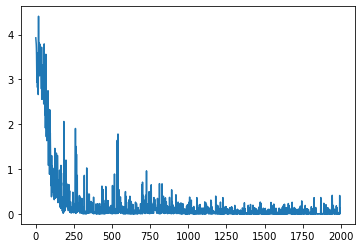

In [23]:
import matplotlib.pyplot as plt

plt.plot(policy_loss)
plt.show()

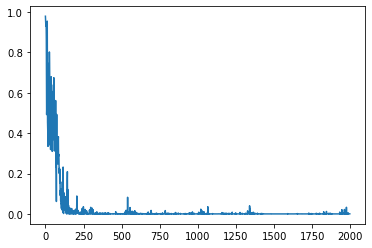

In [24]:
plt.plot(value_loss)
plt.show()